In [14]:
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from shapely import box
import pandas as pd
from geograypher.utils.geospatial import ensure_non_overlapping_polygons
from geograypher.utils.geospatial import ensure_projected_CRS

In [15]:
METADATA_FILE = Path("/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg")
PREDS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions")

ENSURE_NONOVERLAPPING = False
#Quail, BORR, Hastings
RESERVE = "BORR"
ONLY_LEAF_ON = True

# Start and end date as month and year (mmdd)
LEAF_ON_START_DATE = 415
LEAF_ON_END_DATE = 1200

<Axes: >

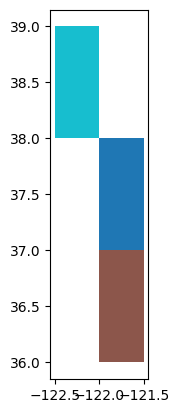

In [16]:
# The generous bounds of the reserves
reserve_bounds = gpd.GeoDataFrame(
    {
        "geometry":
            [
                box(xmin=-122.5, ymin=38, xmax=-122, ymax=39),
                box(xmin=-122, ymin=37, xmax=-121.5, ymax=38),
                box(xmin=-122, ymin=36, xmax=-121.5, ymax=37)
            ],
        "reserve": ["Quail", "BORR", "Hastings"]
    },
    crs=4326
)
reserve_bounds.plot("reserve")

In [17]:
def plot_map(gdf, title=None):
    ax = gdf.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False)
    if title is not None:
        ax.set_title(title)

In [18]:
def compute_standardized(preds, shared_region, reserve, year, ensure_nonoverlapping=False):
    if len(preds) == 0:
        return None

    dissolved = preds.dissolve(by="class_names", as_index=False)
    plot_map(preds, title=f"{year}: before clipping")

    subset = dissolved.clip(shared_region)
    if ensure_nonoverlapping:
        subset = ensure_non_overlapping_polygons(subset)

    plot_map(subset, title=f"{year}: after clipping")
    plt.savefig(Path(f"../data/vis/final_cover_{reserve}_{year}.png"))

    subset = ensure_projected_CRS(subset)
    # Compute the area fraction
    total_area = gpd.GeoDataFrame(data={"geometry": shared_region}, crs=4326).to_crs(subset.crs).area.values[0]

    subset["area_fraction"] = subset.area / total_area
    subset.to_file(Path(f"../data/vis/final_cover_{reserve}_{year}.gpkg"))

    return subset

In [19]:
metadata = gpd.read_file(METADATA_FILE)
metadata = metadata[["mission_id", "earliest_datetime_local_derived"]]

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [20]:
pred_files = sorted(PREDS_FOLDER.glob("*"))

# Load predictions

<Axes: >

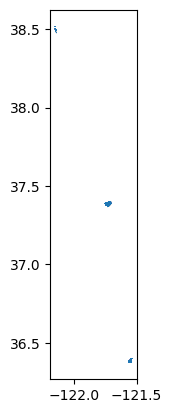

In [21]:
preds = []

for pred_file in pred_files:
    pred = gpd.read_file(pred_file)
    pred["mission_id"] = pred_file.stem
    # Something is weird with this dataset and it's a collection of individual polygons
    if pred_file.stem == "000559":
        pred = pred.dissolve("class_names", as_index=False)

    preds.append(pred)

all_preds = pd.concat(preds)
all_preds.plot()

# Add additional information

In [22]:
# Combine the metadata with the predictions
all_preds = all_preds.merge(metadata, on="mission_id")

# Restrict to the time period that leaves would be one
if ONLY_LEAF_ON:
    # Extract the mmdd representation of the month and day
    int_month_day = all_preds["earliest_datetime_local_derived"].dt.strftime('%m%d').astype(int)

    index = (int_month_day > LEAF_ON_START_DATE) & (int_month_day < LEAF_ON_END_DATE)

    print(f"{len(index) - index.sum()} rows dropped")
    all_preds = all_preds[index]

# Add the information about which reserve it corresponds to
all_preds = gpd.sjoin(all_preds, reserve_bounds, how="left", predicate="intersects")

143 rows dropped


Subset to a single reserve

In [23]:

# Select data only from one reserve if requested
if RESERVE is not None:
    reserve_preds = all_preds[all_preds["reserve"] == RESERVE]
else:
    reserve_preds = all_preds

Split by year

In [24]:
year = reserve_preds["earliest_datetime_local_derived"].dt.year

preds_2020 = reserve_preds[year == 2020]
preds_2023 = reserve_preds[year == 2023]
preds_2024 = reserve_preds[year == 2024]

Compute the shared region across non-empty reserves

<Axes: >

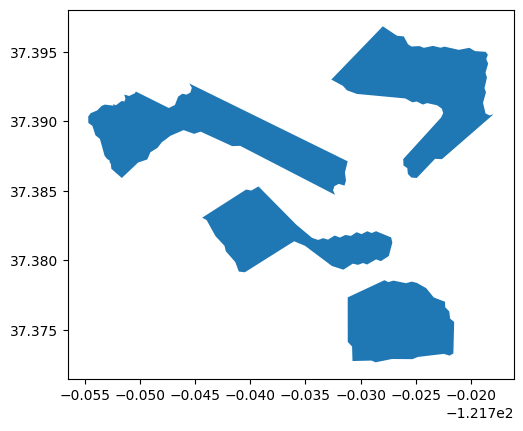

In [25]:
boundary_2020 = preds_2020.dissolve()
boundary_2023 = preds_2023.dissolve()
boundary_2024 = preds_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
shared_region = pd.concat((boundary_2020, boundary_2023, boundary_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023) > 0:
    shared_region = shared_region.intersection(boundary_2023)
if len(boundary_2024) > 0:
    shared_region = shared_region.intersection(boundary_2024)

shared_region.plot()

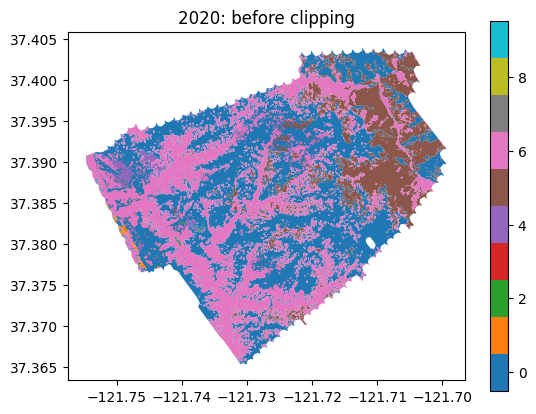

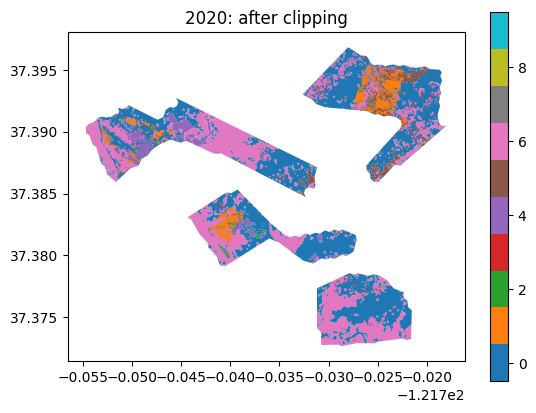

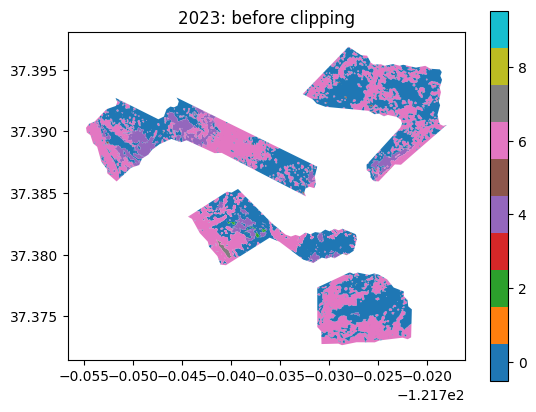

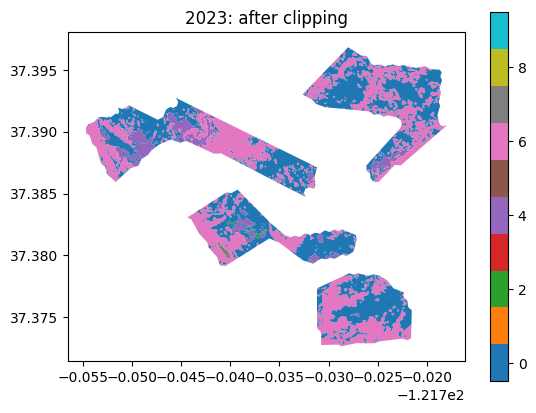

In [27]:
if True:
    standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020")
    standardized_2023 = compute_standardized(preds_2023, shared_region, reserve=RESERVE, year="2023")
    standardized_2024 = compute_standardized(preds_2024, shared_region, reserve=RESERVE, year="2024")
else:
    import geopandas as gpd
    standardized_2020 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2020.gpkg")
    standardized_2023 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2023.gpkg")
    standardized_2024 = gpd.read_file(f"../data/vis/final_cover_{RESERVE}_2024.gpkg")

Make a table to summarize the class fractions per

In [ ]:
final_table = np.zeros((8,3))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023 is not None:
    final_table[standardized_2023["class_ID"].to_numpy().astype(int), 1] = standardized_2023["area_fraction"]
if standardized_2024 is not None:
    final_table[standardized_2024["class_ID"].to_numpy().astype(int), 2] = standardized_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023", "2024"],
    index=["Bare Earth", "Herbaceous Live", "Man Made", "Shrub Dead", "Shrub Live", "Tree Dead", "Tree Live", "Water"])
final_table_vis

,2020,2023,2024
Bare Earth,0.470118,0.312834,0.251827
Herbaceous Live,0.000001,0.000000,0.076582
Man Made,0.001530,0.001082,0.001519
Shrub Dead,0.000092,0.000001,0.000000
Shrub Live,0.101142,0.222249,0.194716
Tree Dead,0.056679,0.002232,0.005857
Tree Live,0.371803,0.461602,0.469498
Water,0.000000,0.000000,0.000000


In [ ]:
standardized_2020_new = standardized_2020.copy()
standardized_2023_new = standardized_2023.copy()

standardized_2020_new.geometry = standardized_2020.buffer(0)
standardized_2023_new.geometry = standardized_2023.buffer(0)

In [30]:
overlaid_2020_2023 = standardized_2020_new.overlay(standardized_2023_new)

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 21270 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [31]:
overlaid_2020_2023

,class_names_1,class_ID_1,mission_id_1,earliest_datetime_local_derived_1,index_right_1,reserve_1,area_fraction_1,class_names_2,class_ID_2,mission_id_2,earliest_datetime_local_derived_2,index_right_2,reserve_2,area_fraction_2,geometry
0,SD_shrub_dead,3.0,000559,2020-10-26 21:06:22+00:00,1,BORR,0.000448,SL_shrub_live,4.0,000610,2023-08-17 16:17:37+00:00,1,BORR,8.543832e-02,"MULTIPOLYGON (((612533.598 4137784.628, 612533..."
1,SD_shrub_dead,3.0,000559,2020-10-26 21:06:22+00:00,1,BORR,0.000448,TL_tree_live,6.0,000610,2023-08-17 16:17:37+00:00,1,BORR,4.384814e-01,"MULTIPOLYGON (((611662.296 4138819.062, 611662..."
2,SD_shrub_dead,3.0,000559,2020-10-26 21:06:22+00:00,1,BORR,0.000448,BE_bare_earth,0.0,000610,2023-08-17 16:17:37+00:00,1,BORR,4.705306e-01,"MULTIPOLYGON (((611466.161 4138186.263, 611466..."
3,SL_shrub_live,4.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.056929,SL_shrub_live,4.0,000610,2023-08-17 16:17:37+00:00,1,BORR,8.543832e-02,"MULTIPOLYGON (((613281.669 4139108.301, 613281..."
4,SL_shrub_live,4.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.056929,TL_tree_live,6.0,000610,2023-08-17 16:17:37+00:00,1,BORR,4.384814e-01,"MULTIPOLYGON (((613247.458 4139114.708, 613247..."
5,SL_shrub_live,4.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.056929,BE_bare_earth,0.0,000610,2023-08-17 16:17:37+00:00,1,BORR,4.705306e-01,"MULTIPOLYGON (((610442.749 4138503.832, 610442..."
6,SL_shrub_live,4.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.056929,MM_man_made_object,2.0,000611,2023-08-17 16:46:11+00:00,1,BORR,1.351680e-03,"MULTIPOLYGON (((611776.584 4137969.157, 611777..."
7,TL_tree_live,6.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.420876,W_water,7.0,000611,2023-08-17 16:46:11+00:00,1,BORR,2.556193e-03,"MULTIPOLYGON (((611560.491 4137755.033, 611560..."
8,TL_tree_live,6.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.420876,SL_shrub_live,4.0,000610,2023-08-17 16:17:37+00:00,1,BORR,8.543832e-02,"MULTIPOLYGON (((613280.466 4139104.920, 613280..."
9,TL_tree_live,6.0,000546,2020-05-09 14:00:16+00:00,1,BORR,0.420876,TL_tree_live,6.0,000610,2023-08-17 16:17:37+00:00,1,BORR,4.384814e-01,"MULTIPOLYGON (((610530.003 4138457.058, 610528..."


In [33]:
transition_matrix_2020_2023 = np.zeros((8,8))

# TODO figure out what these should be
i_inds = overlaid_2020_2023["class_ID_1"].to_numpy().astype(int)
j_inds = overlaid_2020_2023["class_ID_2"].to_numpy().astype(int)
values = overlaid_2020_2023.area.to_numpy()

transition_matrix_2020_2023[i_inds, j_inds] = values

print(transition_matrix_2020_2023)


[[1.03980835e+06 0.00000000e+00 1.08309215e+03 1.81410530e+00
  5.10204428e+04 1.06822311e+03 1.56467738e+05 4.66139806e+02]
 [1.02896636e+05 0.00000000e+00 3.12543524e+02 0.00000000e+00
  3.38577053e+03 3.65504678e+02 3.06719408e+04 0.00000000e+00]
 [1.17086571e+03 0.00000000e+00 2.15404803e+03 0.00000000e+00
  7.94906959e+01 0.00000000e+00 6.01644878e+01 0.00000000e+00]
 [7.29183741e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.86459085e+02 0.00000000e+00 3.56765623e+01 0.00000000e+00]
 [7.48891414e+03 0.00000000e+00 1.28464021e+01 0.00000000e+00
  1.17031862e+05 0.00000000e+00 6.33283879e+03 0.00000000e+00]
 [1.71324695e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.44068747e+04 2.40154747e+03 8.43642109e+04 0.00000000e+00]
 [4.80170077e+04 3.92242299e+00 1.37820930e+01 0.00000000e+00
  3.40478936e+04 1.62490000e+03 8.83302038e+05 4.92418412e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.04413767e+02 4.91756662e+03]]

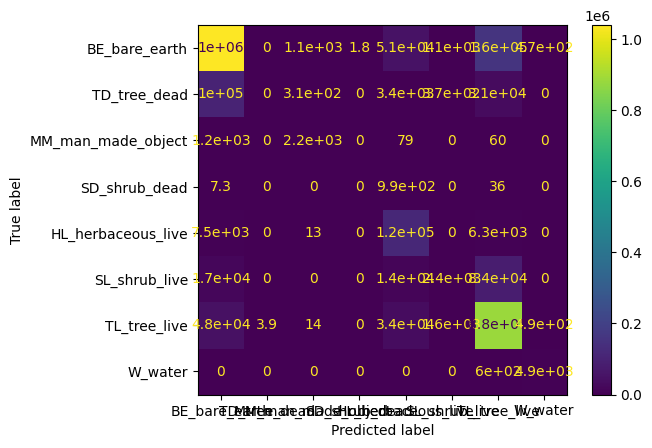

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = standardized_2020["class_names"].to_numpy()[standardized_2020["class_ID"].to_numpy().astype(int)]
ConfusionMatrixDisplay(transition_matrix_2020_2023, display_labels=class_names).plot()
plt.show()